In [267]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [268]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.colors import ListedColormap
from ObjectIdentification import ObjectIdentification
obj_id = ObjectIdentification()

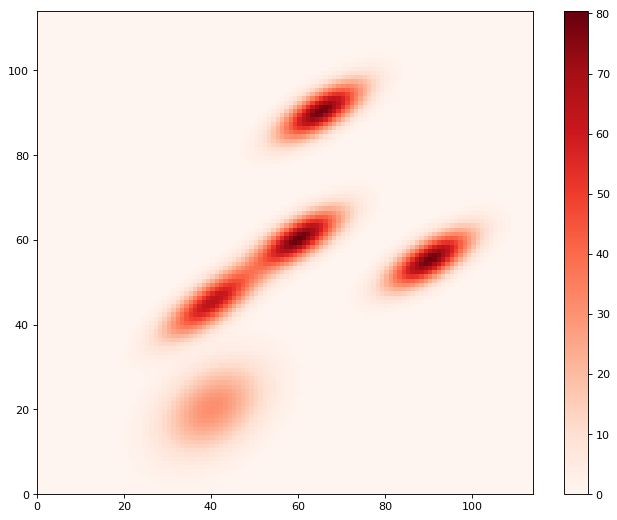

In [269]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
g_len = 115
grid = np.zeros((2, g_len, g_len))
labels = np.zeros((2, g_len, g_len), dtype=int)
x, y = np.meshgrid(np.arange(g_len), np.arange(g_len))
coords = np.dstack((x, y))
peak1_t0 = 10000 * multivariate_normal(mean=[40, 45], cov=np.array([[50, 30], [30, 30]])).pdf(coords)
peak2_t0 = 10000 * multivariate_normal(mean=[60, 60], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak3_t0 = 10000 * multivariate_normal(mean=[65, 90], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak4_t0 = 10000 * multivariate_normal(mean=[90,55], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak5_t0 = 10000 * multivariate_normal(mean=[40,20], cov=np.array([[60, 20], [20, 50]])).pdf(coords) 

peak1_t1 = 10000 * multivariate_normal(mean=[50, 55], cov=np.array([[50, 30], [30, 30]])).pdf(coords)
peak2_t1 = 10000 * multivariate_normal(mean=[75, 70], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak3_t1 = 10000 * multivariate_normal(mean=[75, 110], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak4_t1 = 10000 * multivariate_normal(mean=[95,65], cov=np.array([[40, 20], [20, 20]])).pdf(coords)
peak5_t1 = 10000 * multivariate_normal(mean=[50, 30], cov=np.array([[60, 20], [20, 50]])).pdf(coords) 

grid[0] +=  peak1_t0+peak2_t0+peak3_t0+peak4_t0+peak5_t0
grid[1] +=  peak1_t1+peak2_t1+peak3_t1+peak4_t1+peak5_t1

plt.pcolormesh(x, y, grid[0], cmap="Reds")
plt.colorbar()

# Object Identification

Let's start with a generic 2D field with quasi-discrete peaks (see above). This could represent updraft helicity associated with severe storms, radar reflectivity, or intense rainfall regions, etc. MontePython can perform object identification using a single threshold or the more sophisicated enhanced watershed algorithm (Lakshmanan et al. 2009, Gagne et al. 2016). 

### Single Threshold Method

First, I will demonstrate the single threshold method. I am using the label method in the ObjectIdentification class. We set the `method = 'single_threshold'` and, in the keyword arguments, set the single threshold (`bdry_thresh`) to 20. For this example, I have also set `return_object_properties` to `False` since we only want the object labels. 

In [270]:
labels = obj_id.label( grid[0], method ='single_threshold', return_object_properties=False, 
                      **{'bdry_thresh':20} )

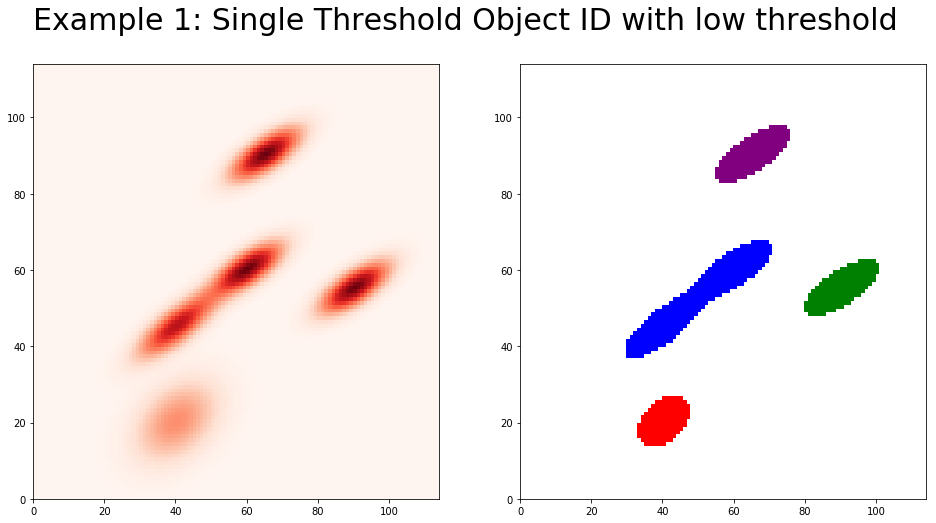

In [271]:
cmap = ListedColormap(["white", "red", "blue", "green", "purple"])
fig, axs = plt.subplots(1,2, figsize=(16,8))

fig.suptitle('Example 1: Single Threshold Object ID with low threshold', fontsize=30)
axs[0].pcolormesh(x, y, grid[0], cmap="Reds")
axs[1].pcolormesh(x,y, labels, cmap=cmap)

The single threshold method performs well for discrete features, but can fail to separate near-by objects (see the red object and compare it to the original field). To separate these features, we can use a higher threshold (see below). However, removing features...
There are pros and cons to the single threshold method.


In [272]:
labels = obj_id.label( grid[0], method ='single_threshold', return_object_properties=False, 
                      **{'bdry_thresh':40} )

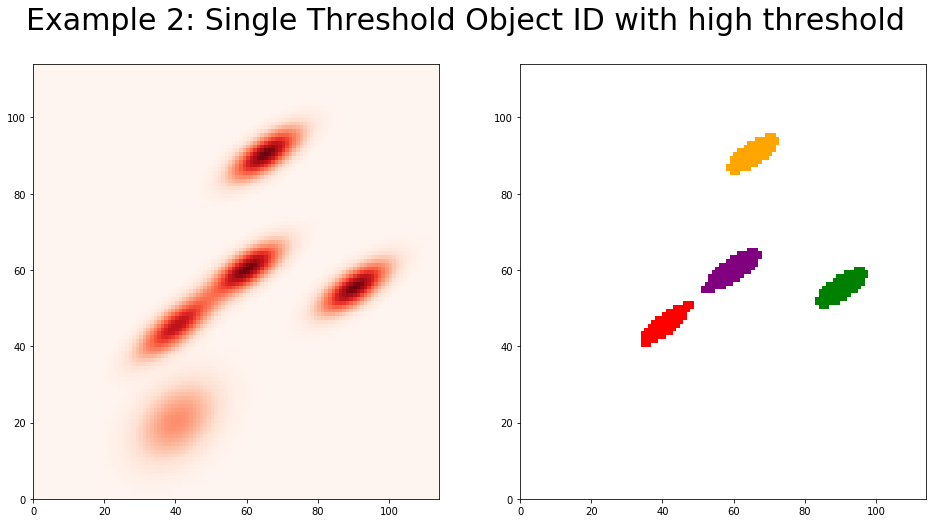

In [273]:
cmap = ListedColormap(["white", "red", "blue", "green", "purple", 'orange'])
fig, axs = plt.subplots(1,2, figsize=(16,8))

fig.suptitle('Example 2: Single Threshold Object ID with high threshold', fontsize=30)
axs[0].pcolormesh(x, y, grid[0], cmap="Reds")
axs[1].pcolormesh(x,y, labels, cmap=cmap)

## Enhanced Watershed Method

As a more sophisicated alternative, we can use the enhanced watershed algorithm. 
Pros
1. Can Separate Near-by objects

Cons
1. May shrink objects
2. Requires more tuning


143
83
89
39
89


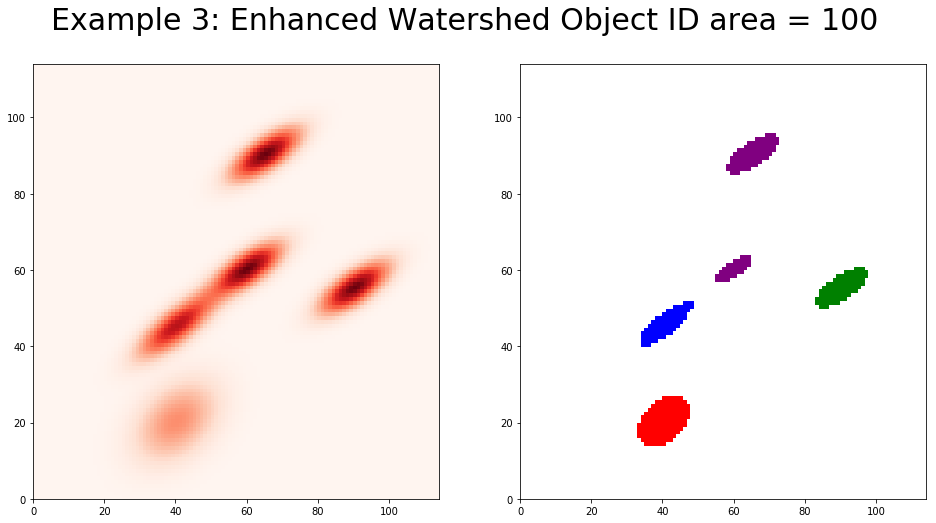

In [274]:
for area in [100]: 
    labels, label_properties = obj_id.label( grid[0], method ='watershed', return_object_properties=True, 
                      **{'min_thresh':20,
                         'max_thresh':100,
                         'data_increment':20,
                         'delta':1,
                         'size_threshold_pixels': area,
                         'local_max_area':100} )
    for region in label_properties:
        print (region.area)
    cmap = ListedColormap(["white", "red", "blue", "green", "purple"])
    fig, axs = plt.subplots(1,2, figsize=(16,8))

    fig.suptitle('Example 3: Enhanced Watershed Object ID area = {}'.format(area), fontsize=30)
    axs[0].pcolormesh(x, y, grid[0], cmap="Reds")
    axs[1].pcolormesh(x,y, labels, cmap=cmap)

# Object Matching

For object matching, MontePython using the following total interest score from Skinner et al. (2018)
<br>
<br>
<h3><center>$T = \frac{1}{2} \Big( \frac{c_{max} - c}{c_{max}} + \frac{m_{max} - m}{m_{max}} \Big)\frac{t_{max} - t}{t_{max}}  $</center></h3>
<br>
<br>
where $c$ is the centroid displacement, $m$ is the minimum displacement, and $t$ is timing displacement and the subscript $max$ indicates the maximum allowable displacement for the three variables. 


In [275]:
from ObjectMatching import ObjectMatching
obj_match = ObjectMatching(dist_max = 10, 
                           time_max=1, 
                           score_thresh=0.2, 
                           one_to_one = False, 
                           only_min_dist=False)

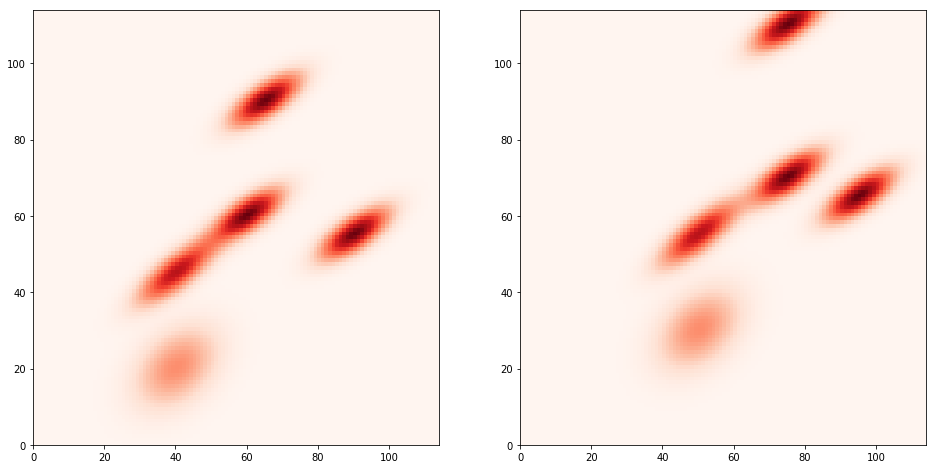

In [276]:
fig, axs = plt.subplots(1,2, figsize=(16,8))
axs[0].pcolormesh(x, y, grid[0], cmap="Reds")
axs[1].pcolormesh(x, y, grid[1], cmap="Reds")

In [277]:
times_a = ['20180501 2300']
# Label the objects in the first grid
labels_0, labels_props0 = obj_id.label( grid[0], method ='watershed', return_object_properties=True, 
                      **{'min_thresh':20,
                         'max_thresh':100,
                         'data_increment':20,
                         'delta':1,
                         'size_threshold_pixels': 150,
                         'local_max_area':100} )

# Label the objects in the second grid 
labels_1, labels_props1 = obj_id.label( grid[1], method ='watershed', return_object_properties=True, 
                      **{'min_thresh':20,
                         'max_thresh':100,
                         'data_increment':20,
                         'delta':1,
                         'size_threshold_pixels': 150,
                         'local_max_area':100} )
# Match the objects 
matched_0, matched_1, _ = obj_match.match_objects([labels_0], [labels_1], times_a = times_a, times_b=times_a)

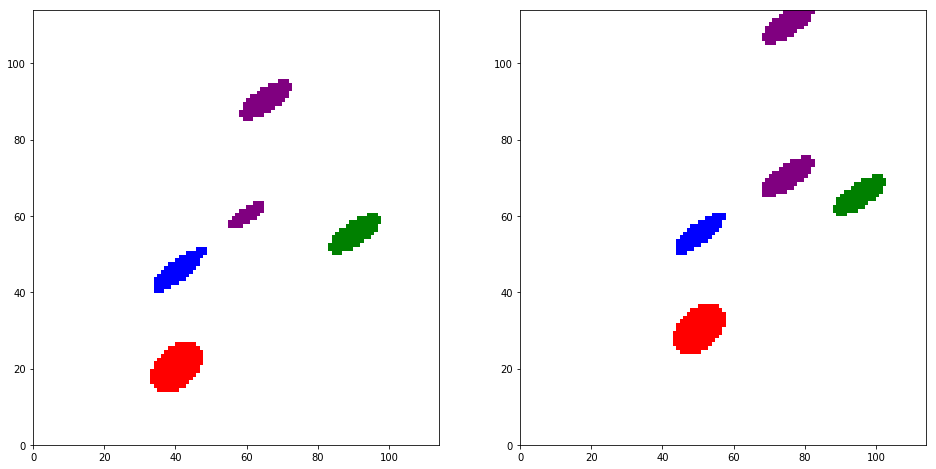

In [278]:
fig, axs = plt.subplots(1,2, figsize=(16,8))
axs[0].pcolormesh(x, y, labels_0, cmap=cmap)
axs[1].pcolormesh(x, y, labels_1, cmap=cmap)

In [279]:
print matched_0, matched_1

[(4, '20180501 2300'), (2, '20180501 2300'), (1, '20180501 2300'), (3, '20180501 2300')] [(2, '20180501 2300'), (2, '20180501 2300'), (1, '20180501 2300'), (3, '20180501 2300')]


In [280]:
def get_centroid(label_props):
    '''Creates a dictionary with the object labels as keys 
    and the tuple of centroid coordinates as items'''
    centroids = {}
    for region in label_props:
        centroids[region.label] = region.centroid
    return centroids
        
label_cent_0 = get_centroid(labels_props0)    
label_cent_1 = get_centroid(labels_props1)

def trajectory(label_cent_0, label_cent_1, matched_0, matched_1):
    '''Associate matched objects and create their trajectory'''
    x_set = []
    y_set = []
    for label_0, label_1 in zip(matched_0, matched_1):
        cent_0 = label_cent_0[label_0[0]]
        cent_1 = label_cent_1[label_1[0]]
        
        x1 = (cent_0[1], cent_1[1])
        y1 = (cent_0[0], cent_1[0])
        x_set.append(x1)
        y_set.append(y1)
    return x_set, y_set
    
x_set, y_set = trajectory(label_cent_0, label_cent_1, matched_0, matched_1)

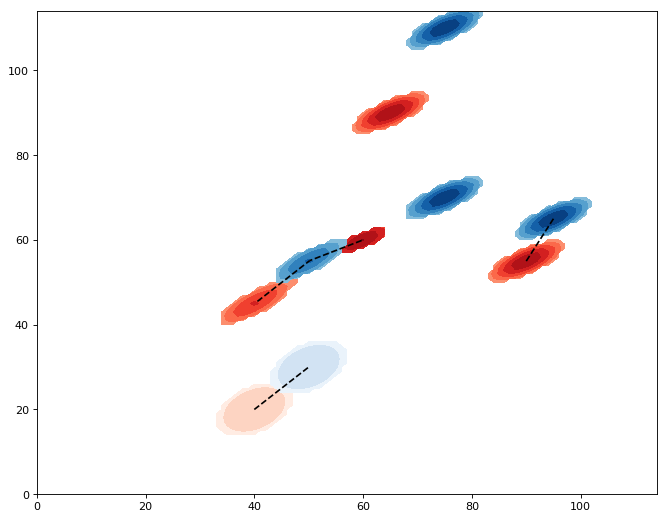

In [265]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
x, y = np.meshgrid(np.arange(g_len), np.arange(g_len))
plt.contourf(x, y, np.ma.array(grid[0], mask=labels_0 == 0), cmap='Reds', conts = np.arange(10, 90, 10))
plt.contourf(x, y, np.ma.array(grid[1], mask=labels_1 == 0), cmap='Blues', conts = np.arange(10, 90, 10))
for x, y in zip(x_set, y_set):
    plt.plot(x,y, linestyle='dashed', color='k')
